In [1]:
# Imports
from torch.nn.functional import binary_cross_entropy
from torch.utils.data import DataLoader
import esm
from torch import nn
import numpy as np
import torch.optim as optim
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
import seaborn as sns
import torch
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
# Accessing GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Loading in data
train_data = pd.read_csv('Data/train_data.csv')
val_data = pd.read_csv('Data/val_data.csv')
test_data = pd.read_csv('Data/test_data.csv')

In [4]:
# Encoding sequences
from preprocessing import aa_encode

# Removing unknown amino acids
unknown_aa = ['O', 'U', 'X']

# Create a mask to identify sequences containing any of the unknown residue symbols
train_mask = train_data['sequence'].apply(lambda seq: any(aa in unknown_aa for aa in seq))
val_mask = val_data['sequence'].apply(lambda seq: any(aa in unknown_aa for aa in seq))
test_mask = test_data['sequence'].apply(lambda seq: any(aa in unknown_aa for aa in seq))

# Filter the data to keep only the rows where the sequence does not contain any unknown residue symbols
train_data = train_data[train_mask == False]
val_data = val_data[val_mask == False]
test_data = test_data[test_mask == False]

In [5]:
from ESM2Dataset import ESM2Dataset
from preprocessing import collate_fn

# Load ESM alphabet
esm_model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()

In [6]:
# Create dataset
train_dataset = ESM2Dataset(train_data, batch_converter)
val_dataset = ESM2Dataset(val_data, batch_converter)
test_dataset = ESM2Dataset(test_data, batch_converter)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

In [ ]:
'''
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()

data = [(i, esm_structural_train[i]['seq']) for i in [0,1]]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    plt.title(seq)
'''

In [3]:
def aggregate_attention_maps(attention_weights, aggregation_method='mean'):
    """
    Aggregate attention maps across all layers.
    
    Parameters:
    attention_weights (dict): Dictionary containing attention weights for each layer
    aggregation_method (str): Method to aggregate attention weights ('mean', 'max', or 'sum')
    
    Returns:
    numpy.ndarray: Aggregated attention map
    """
    # Stack all attention maps
    all_maps = []
    for layer_name in sorted(attention_weights.keys()):
        layer_attention = attention_weights[layer_name][0].cpu().numpy()  # First batch item
        all_maps.append(layer_attention)
    
    # Convert to numpy array for easier manipulation
    all_maps = np.array(all_maps)
    
    # Aggregate across layers based on specified method
    if aggregation_method == 'mean':
        aggregated_map = np.mean(all_maps, axis=0)
    elif aggregation_method == 'max':
        aggregated_map = np.max(all_maps, axis=0)
    elif aggregation_method == 'sum':
        aggregated_map = np.sum(all_maps, axis=0)
    else:
        raise ValueError("Aggregation method must be 'mean', 'max', or 'sum'")
    
    return aggregated_map

def plot_attention_maps(attention_weights, plot_individual=True, aggregation_method='mean'):
    """
    Plot individual layer attention maps and aggregated map.
    
    Parameters:
    attention_weights (dict): Dictionary containing attention weights for each layer
    plot_individual (bool): Whether to plot individual layer maps
    aggregation_method (str): Method to aggregate attention weights
    """
    # Plot individual layer maps if requested
    if plot_individual:
        num_layers = len(attention_weights)
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()
        
        for idx, layer_name in enumerate(sorted(attention_weights.keys())):
            attention_map = attention_weights[layer_name][0].cpu().numpy()
            sns.heatmap(attention_map, cmap="viridis", ax=axes[idx])
            axes[idx].set_title(f"Layer {idx}")
            axes[idx].set_xlabel("Tokens")
            axes[idx].set_ylabel("Tokens")
        
        plt.tight_layout()
        plt.show()
    
    # Plot aggregated map
    plt.figure(figsize=(10, 8))
    aggregated_map = aggregate_attention_maps(attention_weights, aggregation_method)
    sns.heatmap(aggregated_map, cmap="viridis")
    plt.title(f"Aggregated Attention Map ({aggregation_method})")
    plt.xlabel("Tokens")
    plt.ylabel("Tokens")
    plt.show()
    
    return aggregated_map

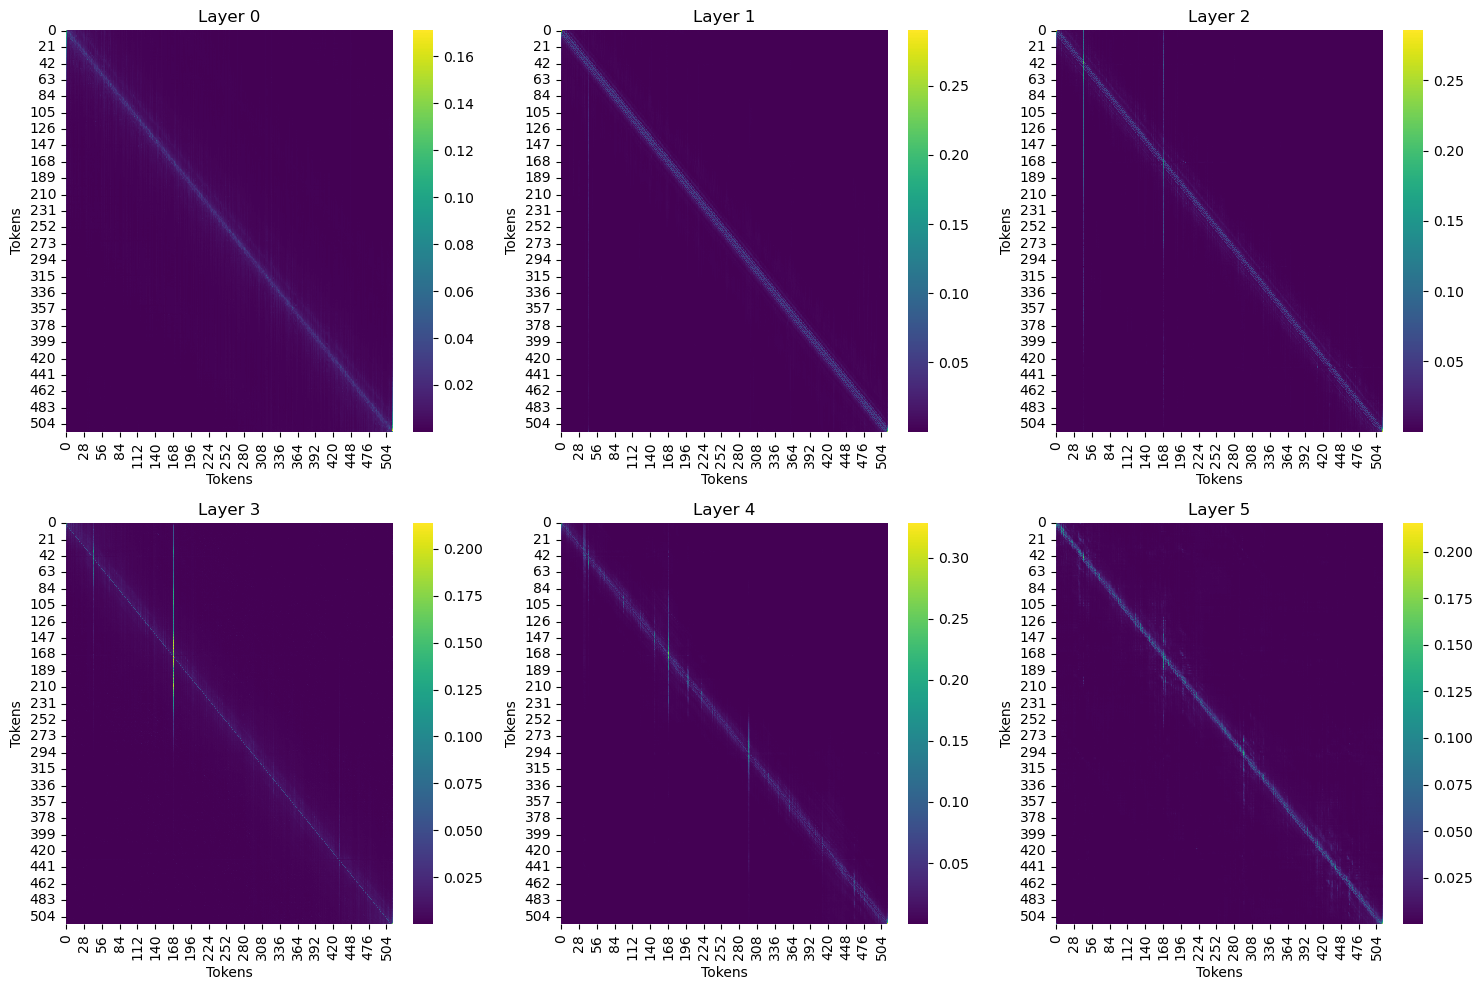

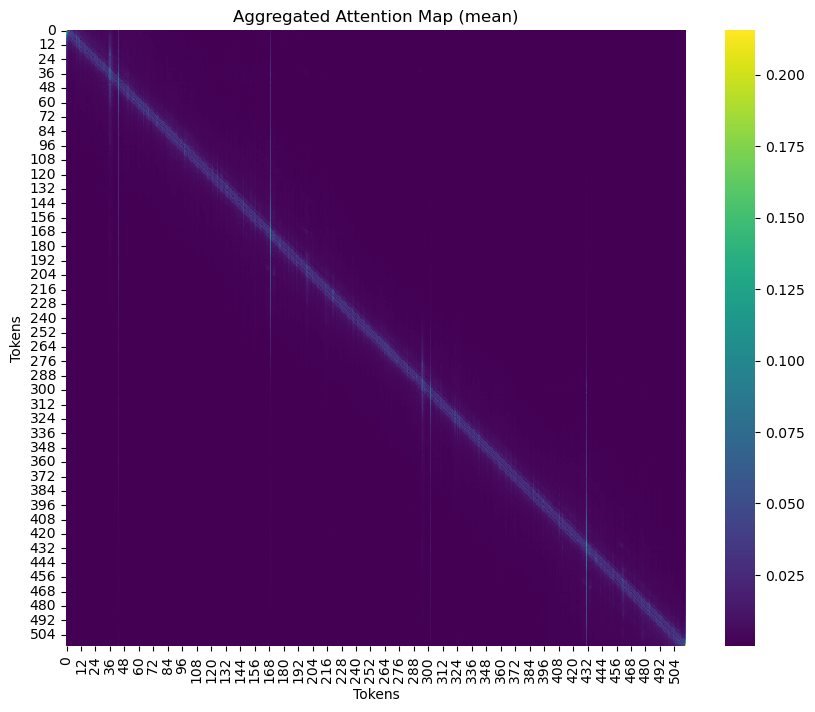

In [4]:
from esm import pretrained
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Load the model and alphabet
esm_model, alphabet = pretrained.esm2_t6_8M_UR50D()

# Function to store attention weights
attention_weights = {}

# Modified hook registration to avoid closure issues
def get_hook(layer_idx):
    def hook(module, input, output):
        attention_weights[f"layer_{layer_idx}"] = output[1]
    return hook

# Register hooks using the modified approach
for idx, layer in enumerate(esm_model.layers):
    layer.self_attn.register_forward_hook(get_hook(idx))

# Rest of your code remains the same
batch_converter = alphabet.get_batch_converter()
data = [("example", "MADYLLEMKNIVKEFGGVRALNGIDIKLKAGECAGLCGENGAGKSTLMKVLSAVYPHGTWDGEILWDGKPLRAQSIRETEAAGIVIIHQELMLVPELSVAENIFLGNEIKLPGGRMDYAAMNRRAEELLAELDIRDVNVVLPVKQYGGGYQQLIEIAKALNKNARLLILDEPSSSLTASEIKVLLRIIHSLKAKGVTCVYISHKLDEVADICDTIVVIRDGQHIATTPMADMNIERIIAQMVGREMNQLYPERSHVPGEVIFEARNVSCYDADNPQRKRVDNISFKLRKGEILGIAGLVGAGRTELVSALFGAYPGPSEAEVWLNGVKLDTRTPLKAIRAGLAMVPEDRKQHGIVPDLGVGHNMTLAVLNDFVRATRIDQQAELATIHKEIKSVKLKTATPFLPITSLSGGNQQKAVLSKMLLTKPKILILDEPTRGVDVGAKFEIYQLMFDLAAQGMSIIMVSSELAEVLGISDRVLVVGEGKLRGDFVNDNLSQETVLAAALDHTQPALH")]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

# Move tokens to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
esm_model = esm_model.to(device)
batch_tokens = batch_tokens.to(device)

# Run the forward pass
esm_model.eval()
with torch.no_grad():
    results = esm_model(batch_tokens)

# Create the aggregated attention map
aggregated_map = plot_attention_maps(attention_weights, plot_individual=True, aggregation_method='mean')

In [6]:
import torch
import torch.nn as nn

class ARGTransformer(nn.Module):
    def __init__(self, vocab_size, max_seq_length, embedding_dim=320, num_classes=1, num_heads=8, num_layers=2, dropout=0.1):
        super(ARGTransformer, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.pos_encoder = nn.Parameter(torch.randn(1, max_seq_length, embedding_dim))
        
        # Store number of heads for reshaping attention
        self.num_heads = num_heads
        
        # Modified attention layers storage
        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.fc = nn.Linear(embedding_dim, num_classes)
        
        # Dictionary to store attention weights (ESM2 style)
        self.attention_weights = {}

    def forward(self, batch_tokens, attention_mask, collect_attention=False):
        # Reset attention weights dictionary
        self.attention_weights = {}
        
        # Embedding
        x = self.embedding(batch_tokens)
        
        # Add positional encoding
        seq_len = x.size(1)
        x = x + self.pos_encoder[:, :seq_len, :]
        
        # Transpose for MultiheadAttention
        x = x.transpose(0, 1)
        
        # Process each attention layer
        for idx, attention_layer in enumerate(self.attention_layers):
            # Compute attention
            attn_output, attn_weights = attention_layer(
                x, x, x,
                key_padding_mask=attention_mask == 0,
                need_weights=True,
                average_attn_weights=False  # Get separate attention weights per head
            )
            
            if collect_attention:
                # Reshape attention weights to match ESM2 format
                # ESM2 format: [batch_size, num_heads, seq_length, seq_length]
                # Current format: [batch_size * num_heads, seq_length, seq_length]
                batch_size = batch_tokens.size(0)
                reshaped_weights = attn_weights.view(batch_size, self.num_heads, seq_len, seq_len)
                
                # Flip the attention weights to match ESM2's orientation
                reshaped_weights = torch.flip(reshaped_weights, [2])  # Flip along sequence dimension
                
                # Store in ESM2-style dictionary
                self.attention_weights[f"layer_{idx}"] = reshaped_weights
            
            # Apply dropout and layer normalization
            x = self.layer_norm(attn_output + x)
        
        # Final processing
        x = x.transpose(0, 1)
        x_mean = x.mean(dim=1)
        logits = self.fc(x_mean)
        
        if collect_attention:
            return logits, self.attention_weights
        return logits

# Modified plotting function specifically for your model
def plot_arg_attention_maps(model_output, plot_individual=True, aggregation_method='mean'):
    """
    Plot attention maps for ARGTransformer in ESM2 style
    """
    attention_weights = model_output[1]  # Get attention weights from model output
    
    if plot_individual:
        num_layers = len(attention_weights)
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()
        
        for idx, layer_name in enumerate(sorted(attention_weights.keys())):
            attention_map = attention_weights[layer_name][0].cpu().numpy()  # First batch item
            sns.heatmap(attention_map.mean(axis=0), cmap="viridis", ax=axes[idx])  # Average over heads
            axes[idx].set_title(f"Layer {idx}")
            axes[idx].set_xlabel("Sequence Position")
            axes[idx].set_ylabel("Sequence Position")
        
        plt.tight_layout()
        plt.show()
    
    # Create aggregated map
    all_maps = []
    for layer_name in sorted(attention_weights.keys()):
        layer_attention = attention_weights[layer_name][0].cpu().numpy()  # First batch item
        all_maps.append(layer_attention.mean(axis=0))  # Average over heads
    
    all_maps = np.array(all_maps)
    
    if aggregation_method == 'mean':
        aggregated_map = np.mean(all_maps, axis=0)
    elif aggregation_method == 'max':
        aggregated_map = np.max(all_maps, axis=0)
    elif aggregation_method == 'sum':
        aggregated_map = np.sum(all_maps, axis=0)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(aggregated_map, cmap="viridis")
    plt.title(f"Aggregated Attention Map ({aggregation_method})")
    plt.xlabel("Sequence Position")
    plt.ylabel("Sequence Position")
    plt.show()
    
    return aggregated_map

In [11]:
from preprocessing import aa_encode
aa_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5, 'Q': 6, 'E': 7, 'G': 8, 
           'H': 9, 'I': 10, 'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15, 
           'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20} 
sequence = "MADYLLEMKNIVKEFGGVRALNGIDIKLKAGECAGLCGENGAGKSTLMKVLSAVYPHGTWDGEILWDGKPLRAQSIRETEAAGIVIIHQELMLVPELSVAENIFLGNEIKLPGGRMDYAAMNRRAEELLAELDIRDVNVVLPVKQYGGGYQQLIEIAKALNKNARLLILDEPSSSLTASEIKVLLRIIHSLKAKGVTCVYISHKLDEVADICDTIVVIRDGQHIATTPMADMNIERIIAQMVGREMNQLYPERSHVPGEVIFEARNVSCYDADNPQRKRVDNISFKLRKGEILGIAGLVGAGRTELVSALFGAYPGPSEAEVWLNGVKLDTRTPLKAIRAGLAMVPEDRKQHGIVPDLGVGHNMTLAVLNDFVRATRIDQQAELATIHKEIKSVKLKTATPFLPITSLSGGNQQKAVLSKMLLTKPKILILDEPTRGVDVGAKFEIYQLMFDLAAQGMSIIMVSSELAEVLGISDRVLVVGEGKLRGDFVNDNLSQETVLAAALDHTQPALH"
sequence = aa_encode(sequence, aa_map)
tensor_sequence = torch.tensor(sequence)
label = 0
attention_mask = np.full(len(sequence), True, dtype=bool)
tensor_attention_mask = torch.from_numpy(attention_mask)


model = ARGTransformer(21, len(sequence))

# Forward pass with attention collection
outputs, attention_weights = model(tensor_sequence, tensor_attention_mask, collect_attention=True)

# Plot attention maps
aggregated_map = plot_arg_attention_maps(
    (outputs, attention_weights),
    plot_individual=True,
    aggregation_method='mean'
)

RuntimeError: The size of tensor a (512) must match the size of tensor b (320) at non-singleton dimension 1

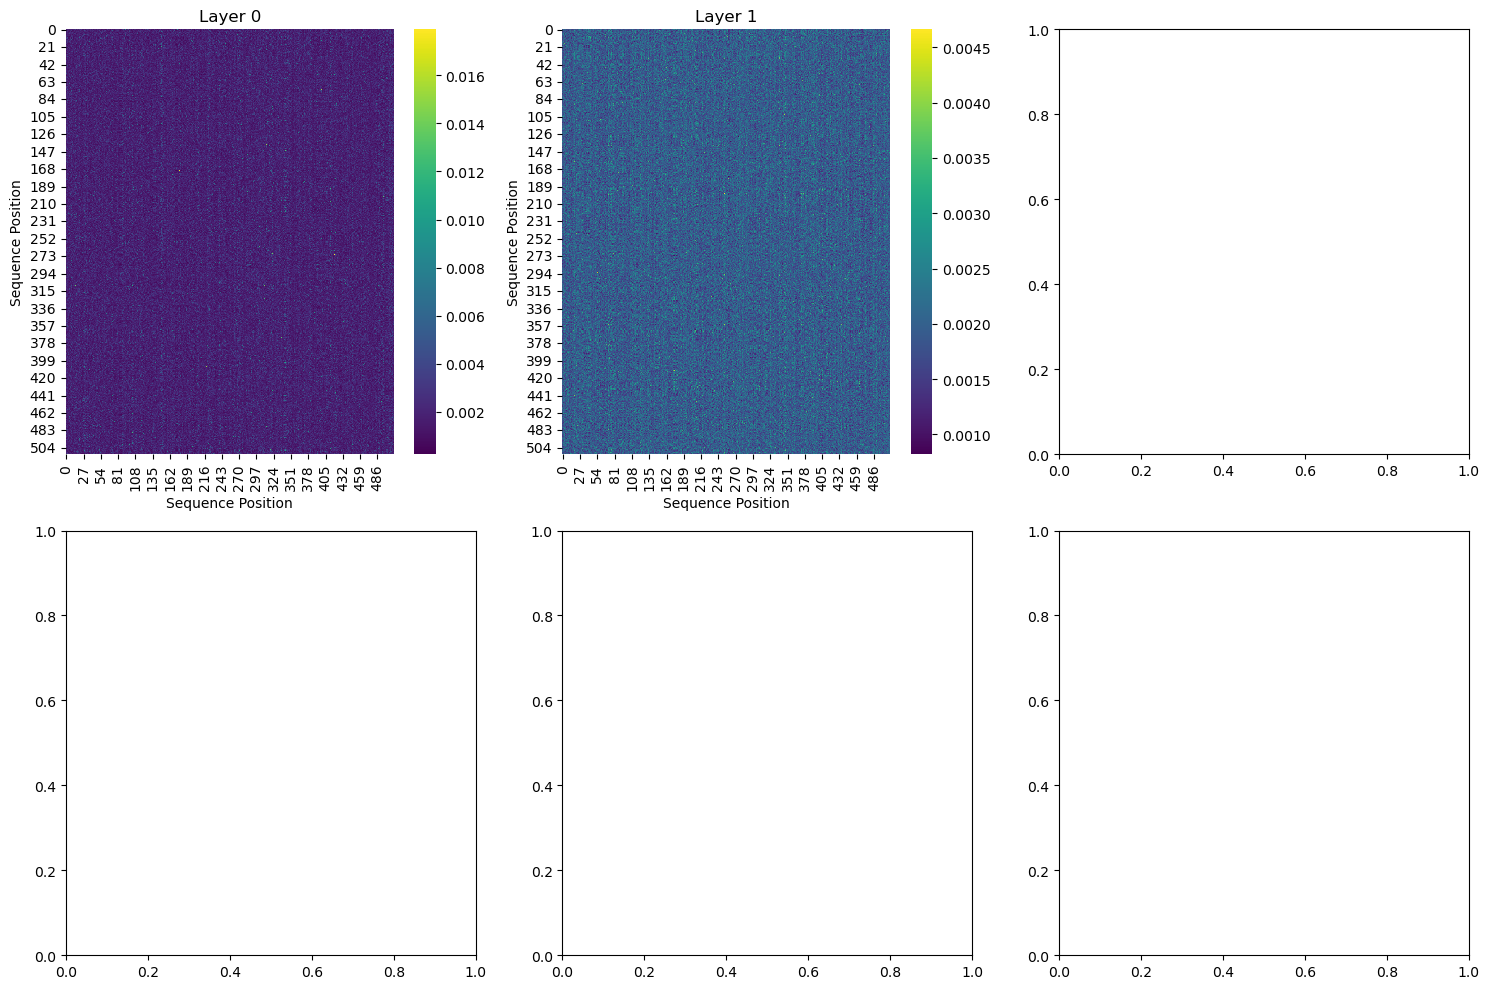

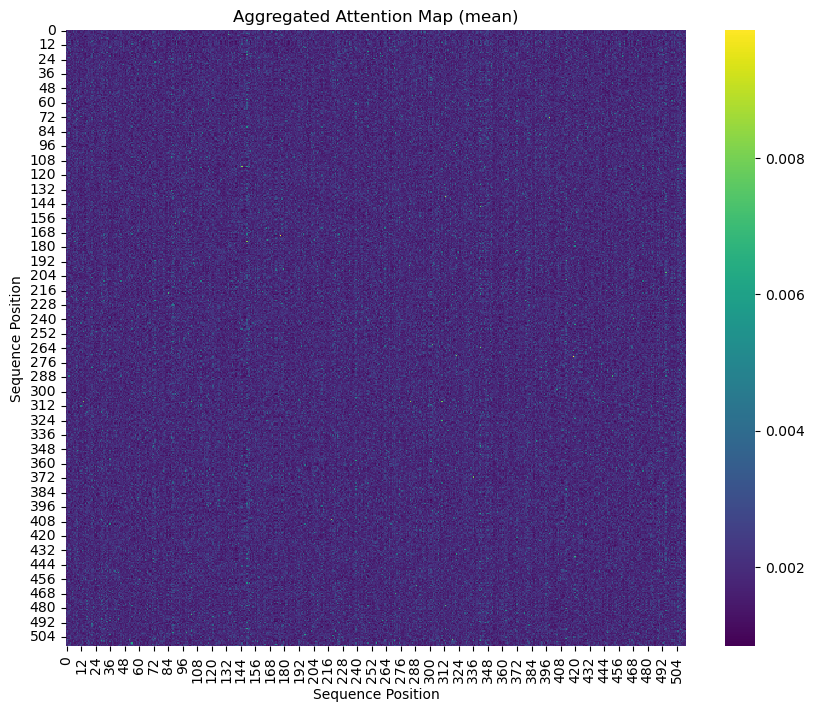

In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class ARGTransformer(nn.Module):
    def __init__(self, vocab_size, max_seq_length, embedding_dim=320, num_classes=1, num_heads=8, num_layers=2, dropout=0.1):
        super(ARGTransformer, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # Initialize positional encoding with correct dimensions
        self.pos_encoder = nn.Parameter(torch.randn(1, max_seq_length, embedding_dim))
        self.num_heads = num_heads
        
        self.attention_layers = nn.ModuleList([
            nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.fc = nn.Linear(embedding_dim, num_classes)
        self.attention_weights = {}

    def forward(self, batch_tokens, attention_mask, collect_attention=False):
        # Reset attention weights dictionary
        self.attention_weights = {}
        
        # Add batch dimension if not present
        if batch_tokens.dim() == 1:
            batch_tokens = batch_tokens.unsqueeze(0)
        if attention_mask.dim() == 1:
            attention_mask = attention_mask.unsqueeze(0)
            
        # Embedding
        x = self.embedding(batch_tokens)  # [batch_size, seq_len, embedding_dim]
        
        # Add positional encoding
        seq_len = x.size(1)
        x = x + self.pos_encoder[:, :seq_len, :]
        
        # Transpose for MultiheadAttention
        x = x.transpose(0, 1)  # [seq_len, batch_size, embedding_dim]
        
        # Process each attention layer
        for idx, attention_layer in enumerate(self.attention_layers):
            # Compute attention
            attn_output, attn_weights = attention_layer(
                x, x, x,
                key_padding_mask=(~attention_mask).bool() if attention_mask.dtype != torch.bool else ~attention_mask,
                need_weights=True,
                average_attn_weights=False
            )
            
            if collect_attention:
                batch_size = batch_tokens.size(0)
                reshaped_weights = attn_weights.view(batch_size, self.num_heads, seq_len, seq_len)
                reshaped_weights = torch.flip(reshaped_weights, [2])
                self.attention_weights[f"layer_{idx}"] = reshaped_weights
            
            x = self.layer_norm(attn_output + x)
        
        x = x.transpose(0, 1)
        x_mean = x.mean(dim=1)
        logits = self.fc(x_mean)
        
        if collect_attention:
            return logits, self.attention_weights
        return logits

# Now use it with your sequence:
sequence = "MADYLLEMKNIVKEFGGVRALNGIDIKLKAGECAGLCGENGAGKSTLMKVLSAVYPHGTWDGEILWDGKPLRAQSIRETEAAGIVIIHQELMLVPELSVAENIFLGNEIKLPGGRMDYAAMNRRAEELLAELDIRDVNVVLPVKQYGGGYQQLIEIAKALNKNARLLILDEPSSSLTASEIKVLLRIIHSLKAKGVTCVYISHKLDEVADICDTIVVIRDGQHIATTPMADMNIERIIAQMVGREMNQLYPERSHVPGEVIFEARNVSCYDADNPQRKRVDNISFKLRKGEILGIAGLVGAGRTELVSALFGAYPGPSEAEVWLNGVKLDTRTPLKAIRAGLAMVPEDRKQHGIVPDLGVGHNMTLAVLNDFVRATRIDQQAELATIHKEIKSVKLKTATPFLPITSLSGGNQQKAVLSKMLLTKPKILILDEPTRGVDVGAKFEIYQLMFDLAAQGMSIIMVSSELAEVLGISDRVLVVGEGKLRGDFVNDNLSQETVLAAALDHTQPALH"
sequence = aa_encode(sequence, aa_map)
tensor_sequence = torch.tensor(sequence, dtype=torch.long)  # Make sure it's long type
attention_mask = torch.ones(len(sequence), dtype=torch.bool)  # Use torch.ones instead of np.full

# Initialize model with matching dimensions
model = ARGTransformer(
    vocab_size=21,
    max_seq_length=len(sequence),
    embedding_dim=320,  # Make sure this matches your desired embedding dimension
    num_heads=8,
    num_layers=2
)

model.eval()
with torch.no_grad():
    # Forward pass with attention collection
    outputs, attention_weights = model(tensor_sequence, attention_mask, collect_attention=True)


# Plot attention maps
aggregated_map = plot_arg_attention_maps(
    (outputs, attention_weights),
    plot_individual=True,
    aggregation_method='mean'
)

In [14]:
def aggregate_hybrid_attention_maps(esm_attention_weights, pytorch_attention_weights, aggregation_method='mean'):
    """
    Aggregate attention maps from both ESM2 and custom PyTorch layers
    """
    # First aggregate ESM2 layers (layers 0-5)
    esm_maps = []
    for layer_name in sorted(esm_attention_weights.keys()):
        layer_attention = esm_attention_weights[layer_name][0].cpu().numpy()
        esm_maps.append(layer_attention)
    
    # Then aggregate PyTorch layers (layers 6-8)
    pytorch_maps = []
    for layer_name in sorted(pytorch_attention_weights.keys()):
        layer_attention = pytorch_attention_weights[layer_name][0].cpu().numpy()
        pytorch_maps.append(layer_attention)
    
    # Convert to numpy arrays
    esm_maps = np.array(esm_maps)
    pytorch_maps = np.array(pytorch_maps)
    
    # Aggregate separately first
    if aggregation_method == 'mean':
        esm_agg = np.mean(esm_maps, axis=0)
        pytorch_agg = np.mean(pytorch_maps, axis=0)
    elif aggregation_method == 'max':
        esm_agg = np.max(esm_maps, axis=0)
        pytorch_agg = np.max(pytorch_maps, axis=0)
    
    # Then combine them with weighting
    # You might want to weight the task-specific PyTorch attention more heavily
    combined_map = 0.5 * esm_agg + 0.5 * pytorch_agg
    
    return combined_map, esm_agg, pytorch_agg

In [ ]:
def plot_hybrid_attention_maps(combined_map, esm_agg, pytorch_agg):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    sns.heatmap(esm_agg, cmap="viridis", ax=ax1)
    ax1.set_title("ESM2 Attention")
    
    sns.heatmap(pytorch_agg, cmap="viridis", ax=ax2)
    ax2.set_title("PyTorch Attention")
    
    sns.heatmap(combined_map, cmap="viridis", ax=ax3)
    ax3.set_title("Combined Attention")
    
    plt.tight_layout()
    plt.show()